In [17]:
!pip install cellpose
import cellpose

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.9/623.9 kB 80.7 MB/s eta 0:00:00


anns.shape: (540, 2, 512, 512)
imgs.shape: (540, 512, 512)
Random index: 97


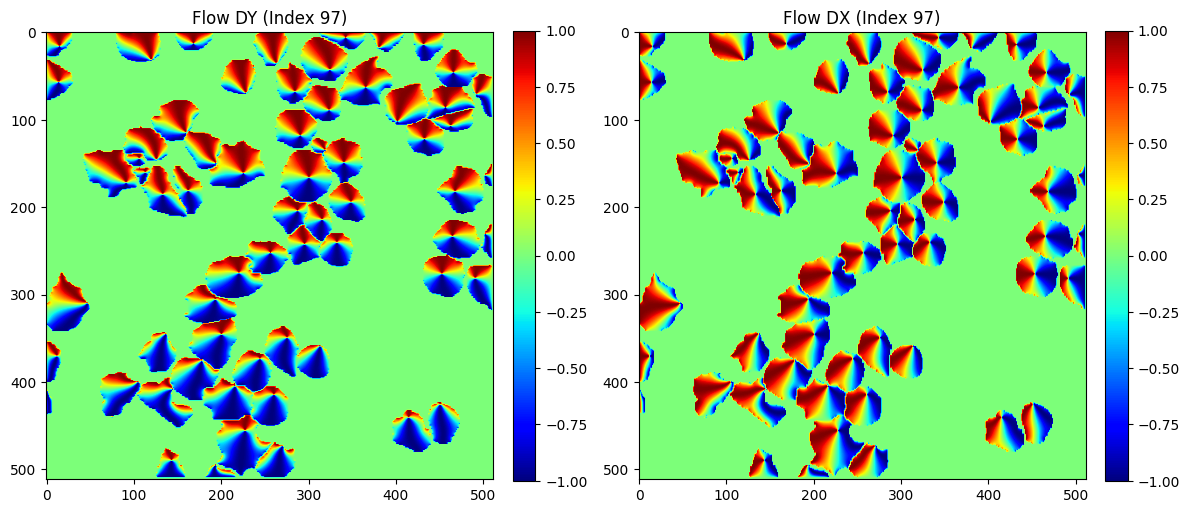

In [27]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from cellpose.dynamics import masks_to_flows

# Path to your labeled mask array
Cellpose_path = '/Users/saahilsanganeriya/Documents/Saahil/PBL/SAMCellv2.0/dataset_processing/CellPose/'
anns_file = Cellpose_path + 'anns.npy'  # or wherever your .npy is
imgs_file = Cellpose_path + 'imgs.npy'
out_file   = Cellpose_path + 'flows.npy'

# Load the array of labeled masks
anns = np.load(anns_file)  # shape could be (N, H, W) or (N, 1, H, W), etc.
print("anns.shape:", anns.shape)

imgs = np.load(imgs_file)
print("imgs.shape:", imgs.shape)

# Number of images
N = anns.shape[0]

# Pick a random index
idx = random.randint(0, N-1)
print("Random index:", idx)

# Extract the labeled mask (assuming it's in channel 0)
label_img = anns[idx, 0].astype(int)

# Convert to flows using Cellpose
flows = masks_to_flows(label_img, device=torch.device('cpu'))
# flows is shape (2, 512, 512)
# flows[0] = dy, flows[1] = dx

flow_dy = flows[0]
flow_dx = flows[1]

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(flow_dy, cmap='jet')
ax1.set_title(f"Flow DY (Index {idx})")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(flow_dx, cmap='jet')
ax2.set_title(f"Flow DX (Index {idx})")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

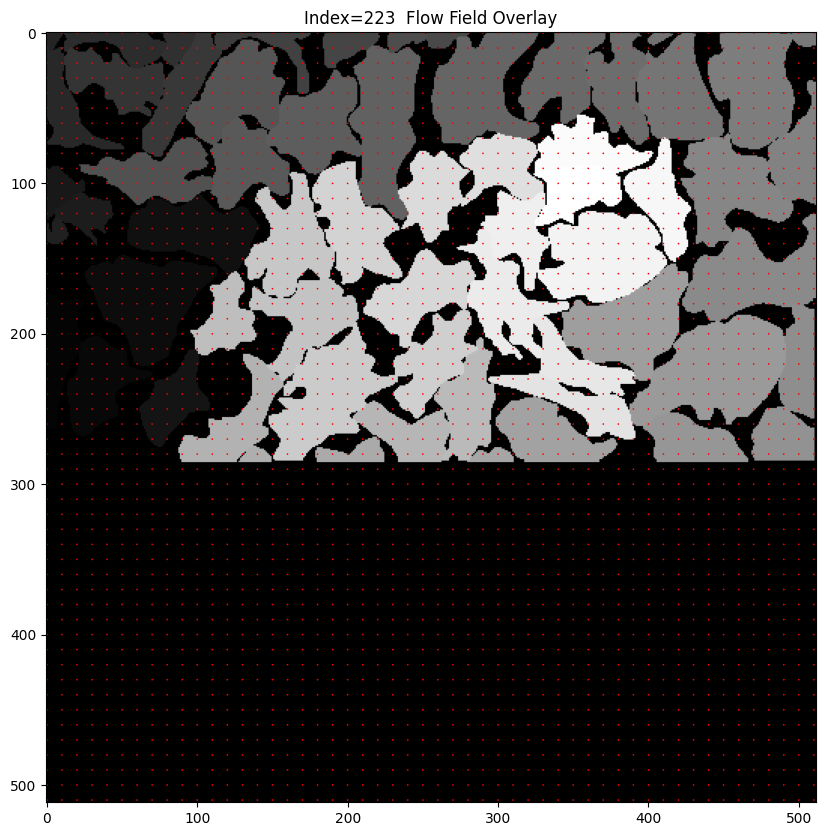

In [26]:
dy, dx = flow_dx, flow_dy  # shape each: (512, 512)

# Subsample grid for quiver arrows
step = 10  # arrow spacing
H, W = dy.shape
y_coords = np.arange(0, H, step)
x_coords = np.arange(0, W, step)
X, Y = np.meshgrid(x_coords, y_coords)

# Extract flow vectors at the sampled points
U = dx[Y, X]  # horizontal flow
V = dy[Y, X]  # vertical flow

# Plot the label image
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(label_img, cmap='gray')
ax.set_title(f"Index={idx}  Flow Field Overlay")

# Plot the flow vectors with a larger scale
ax.quiver(X, Y, U, V, color='red', pivot='middle',
          scale_units='xy', angles='xy', scale=15)

plt.show()


In [22]:
import numpy as np
import torch
from cellpose.dynamics import masks_to_flows

# Path to your labeled mask array
Cellpose_path = '/Users/saahilsanganeriya/Documents/Saahil/PBL/SAMCellv2.0/dataset_processing/CellPose/'
anns_file = Cellpose_path + 'anns.npy'  # or wherever your .npy is
imgs_file = Cellpose_path + 'imgs.npy'
out_file   = Cellpose_path + 'flows.npy'

# Load the array of labeled masks
anns = np.load(anns_file)  # shape could be (N, H, W) or (N, 1, H, W), etc.
print("anns.shape:", anns.shape)

imgs = np.load(imgs_file)
print("imgs.shape:", imgs.shape)

# Decide how to index each mask. 
# Example: if shape is (N, H, W), then ann_i = anns[i]
# If shape is (N, 2, H, W) or (N, 1, H, W), you might do ann_i = anns[i,0]
# Adjust the indexing as needed for your array.
def get_mask(anns, idx):
    # Adjust this depending on your shape
    # e.g. if shape is (N, 2, H, W) and the first channel is the labeled mask:
    return anns[idx, 0]
    # or if shape is (N, H, W): return anns[idx]

N = anns.shape[0]
flows_all = []

# Choose CPU or GPU 
# (GPU is faster if installed, but CPU is simpler to ensure correctness):
device = torch.device('cpu')  # or torch.device('cuda')

random_idx = np.random.randint(0, imgs.shape[0])

# Extract the label image for index i
label_img = get_mask(anns, i)

# Ensure it's int type
label_img = label_img.astype(int)

# Convert to flows. 
# This returns an array shape (2, H, W):
#   flows[0] -> dy
#   flows[1] -> dx
flows = masks_to_flows(label_img, device=device)

# Store them
flows_all.append(flows)

for i in range(N):
    # Extract the label image for index i
    label_img = get_mask(anns, i)
    
    # Ensure it's int type
    label_img = label_img.astype(int)
    
    # Convert to flows. 
    # This returns an array shape (2, H, W):
    #   flows[0] -> dy
    #   flows[1] -> dx
    flows = masks_to_flows(label_img, device=device)
    
    # Store them
    flows_all.append(flows)

# Convert list to array: shape will be (N, 2, H, W)
flows_all = np.array(flows_all, dtype=np.float32)
print("flows_all.shape:", flows_all.shape)

# Save
np.save(out_file, flows_all)
print("Saved flows to:", out_file)

anns.shape: (540, 2, 512, 512)
imgs.shape: (540, 512, 512)
flows_all.shape: (541, 2, 512, 512)
Saved flows to: /Users/saahilsanganeriya/Documents/Saahil/PBL/SAMCellv2.0/dataset_processing/CellPose/flows.npy
